In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib.collections import LineCollection
from shapely.geometry import Point, Polygon, LineString
from os import path, listdir, getcwd
import matplotlib.pyplot as plt
import json
from shapely.geometry import box

from bokeh.models import (ColumnDataSource,
                          CustomJS, HoverTool,
                          LinearColorMapper, Slider, Column,BooleanFilter)
from bokeh.layouts import column, row
from bokeh.io import show, output_file, output_notebook
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.core.properties import value

%matplotlib inline


In [2]:
# Parse and plot data
def read_map(city, dir):
    """
    Reads map data from roads folder into dataframes
    :param city: mny, bj5, ch1
    :param dir: path to roads directory
    :return: nodes: DataFrame       (node_id, x, y)
             edges: GeoDataFrame    (u, v, length)
    """
    with open(path.join(dir, city + '_nodes.js')) as f:
        lines = f.read().split('=')
        node_dict = json.loads(lines[1])
    nodes = pd.DataFrame([[k, *v] for k, v in node_dict.items()], columns=['node_id', 'x','y'])
    nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.x, nodes.y), crs=4326)
        
    with open(path.join(dir, city + '_directed.edges')) as f:
        lines = f.read().split('\n') 
    num_nodes, num_edges = [int(x) for x in lines[0].split(' ')]
    assert nodes.shape[0] == num_nodes
    print('Graph with %s nodes and %s edges' % (num_nodes ,num_edges))

    edge_list = [[int(x) for x in line.split()] for line in lines[1:] if len(line) >0]
    edges = pd.DataFrame(edge_list, columns=['u', 'v', 'length'])
    return nodes, edges


def plot_map(nodes, edges=None):
    
    fig, ax = plt.subplots(figsize=(16,12))
    nodes_coords = np.array([nodes.x.values, nodes.y.values])
    ax.scatter(*nodes_coords, s=2, marker='o')
    if edges is not None:
        edge_coords = edges.apply(lambda e: [[nodes.iloc[e.u].x, nodes.iloc[e.u].y], 
                                         [nodes.iloc[e.v].x, nodes.iloc[e.v].y]], 
                              axis=1)
        lc = LineCollection(edge_coords, linewidths=0.2, colors='gray')
        ax.add_collection(lc)
    ax.autoscale()
    return ax


def read_instance(filename):
    """
    Reads trip data into dataframe
    :param filename: path to instance file
    :return: GeoDataFrame   (id, origin, dest, q, early, late)
    """
    with open(filename) as f:
        lines = f.read().split('\n')
    # inst_name = lines[0]
    header = [l.lower() for l in lines[5].split()]
    lines = lines[6:]
    # data = [(int(x) for x in line.split()) for line in lines ]
    # the instance has errors, one line had 7 values, for instances w/o errors the oneliner should be enough
    data = []
    for line in lines:
        vals = line.split()
        if len(vals) == 6:
            data.append([int(x) for x in vals])
    df = pd.DataFrame(data, columns=header)
    return df


def plot_trips(trips, nodes, car_positions=False):
    """
    
    :param trips: DataFrame (id, origin, dest, ...)
    :param nodes: DataFrame (node_id, x, y,  ....)
    :param car_positions: if true plot car positions with origins
    :return: 
    """
    trips_ = trips[trips.dest >= 0]
    ps = pd.DataFrame(trips_.groupby('origin').size(), columns=['num_trips']).reset_index()
    ds = pd.DataFrame(trips_.groupby('dest').size(), columns=['num_trips']).reset_index()
 
    fig, axes = plt.subplots(ncols=2, figsize=(24, 12))
    p_coords = get_coordinates(nodes, ps.origin)
    axes[0].scatter(*p_coords, c='green', s=ps.num_trips*5)
    if car_positions:
        cars = trips[trips.dest == -1]
        coords = get_coordinates(nodes, cars.origin)
        axes[0].scatter(*coords, c='black', marker='*', s=2)
        
    d_coords = get_coordinates(nodes, ds.dest)
    axes[1].scatter(*d_coords, c='blue', s=ds.num_trips*5)
    
    
def get_coordinates(nodes, ids):
    return np.array([nodes.iloc[ids].x, nodes.iloc[ids].y])

def add_geometry_column(df, nodes, column_name, geoname):
    """
    
    :param df: dataframe
    :param nodes: geodataframe
    :param column_name: name of column
    :param geoname: name of geometry column
    :return: 
    """
    df['x'] = df[column_name].apply(lambda n: nodes.iloc[n].x)
    df['y'] = df[column_name].apply(lambda n: nodes.iloc[n].y)
    geoname = '_'.join([column_name, geoname])
    df[geoname] = gpd.points_from_xy(df.x, df.y)
    df = df.drop(columns=['x', 'y'])
    return df


def df_to_gdf(df, nodes, columns, geoname='geometry'):
    """
    Transforms columns from the list to geometry columns 'column_geometry', 
    'origin' -> 'origin_geometry'.
    Values in the given columns are node_ids from nodes dataframe.
    
    :param df: DataFrame(col1, col2, col3...)
    :param nodes: GeoDataFrame (node_id, x, y)
    :param columns: list[col1, col3 ...]
    :param geoname: str
    :return: GeoDataFrame (col1_geometry, col2_geometry, ...)
    """
    df_ = df[:][:]
    for col in columns:
        df_ = add_geometry_column(df_, nodes, col, geoname)
    
    geoname = '_'.join([columns[0], geoname])
    gdf = gpd.GeoDataFrame(df_, geometry=geoname, crs=4326)
    return gdf
    
    
def save_to_shapefiles(trips, nodes, shp_dir, car_positions=False):
    """
    Saves trips' dropoffs and pickups as .shp files in the given directory.
    If car_positions is True, also saves initial car positions.
    
    :param trips: DataFrame (id, origin, dest, ....) 
    :param nodes: DataFrame/GeoDataFrame (node_id, x, y, *geometry )
    :param shp_dir: path to output directory
    :param car_positions: 
    :return: 
    """
    trips_ = trips[['id','origin', 'dest']]
    
    trips1 = trips_[trips_.dest >= 0]
    trips_gdf = df_to_gdf(trips1, nodes, ['origin', 'dest'])
    
    pickups = trips_gdf.drop(columns='dest_geometry')
    pickups = pickups.set_geometry('origin_geometry', crs=4326)
    pickups.to_file(driver='ESRI Shapefile', filename=path.join(shp_dir, "pickup.shp"))
        
    dropoffs = trips_gdf.drop(columns='origin_geometry')
    dropoffs = dropoffs.set_geometry('dest_geometry', crs=4326)
    dropoffs.to_file(driver='ESRI Shapefile', filename=path.join(shp_dir, "dropoff.shp"))
    
    if car_positions:
        cars_df = trips_[trips_.dest == -1]
        cars_gdf = df_to_gdf(cars_df, nodes, ['origin'])
        cars_gdf.to_file(driver='ESRI Shapefile', filename=path.join(shp_dir, "car_positions.shp"))


In [3]:
ROADS = '/home/olga/PycharmProjects/darp_benchmark/cargo/roads' #path to roads folder
CITIES = ['mny', 'bj5', 'cd1']
#Required files: {city}_nodes.js, {city}_directed.edges 

Graph with 12320 nodes and 31444 edges


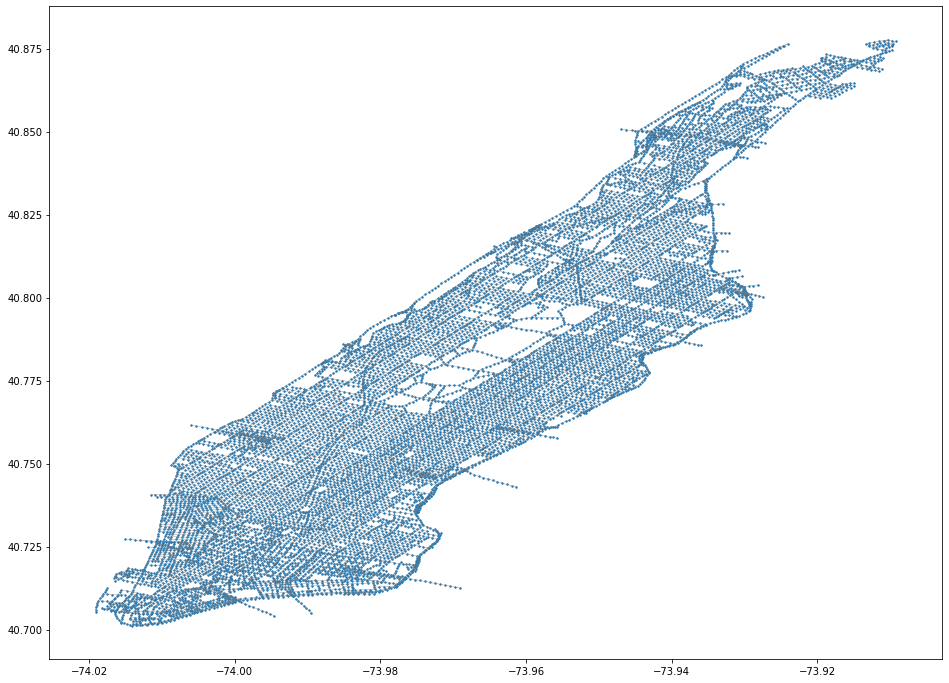

In [4]:
##   Manhattan
mny_nodes, mny_edges = read_map(CITIES[0], ROADS)
plot_map(mny_nodes, mny_edges)


In [5]:
## ny, 10.000 cars, capacity 3, delay 6 min, scale 1, s10- speed 10m/s???
## 5033 customers 
inst1 = 'rs-mny-m10k-c3-d6-s10-x1.0.instance'
trips1 = read_instance(path.join('/home/olga/PycharmProjects/darp_benchmark/cargo/instances', inst1))
# plot_trips(trips1, mny_nodes, car_positions=True)

In [9]:
df = trips1[trips1.dest >= 0].copy()
df['minute'] = df['early']//10
df['x1'] = df.origin.apply(lambda n: mny_nodes.iloc[n].x)
df['y1'] = df.origin.apply(lambda n: mny_nodes.iloc[n].y)
df['x2'] = df.dest.apply(lambda n: mny_nodes.iloc[n].x)
df['y2'] = df.dest.apply(lambda n: mny_nodes.iloc[n].y)
df['xx'] = df.apply(lambda r: [r.x1, r.x2], axis=1)
df['yy'] = df.apply(lambda r: [r.y1, r.y2], axis=1)
# print(df.head())


source0 = ColumnDataSource(data=dict(min=df.minute.values, x1=df.x1.values, y1=df.y1.values,
                                                           x2=df.x2.values, y2=df.y2.values,
                                                           xx=df.xx.values, yy=df.yy.values))
df1 = df[df['minute'] == 0].copy()
source1 = ColumnDataSource(data=df1)

plot = figure(plot_width=1200, plot_height=800)
plot.circle('x1', 'y1', source=source0, line_alpha=0.4, size=2, color='black')
pickups = plot.circle('x1', 'y1', source=source1, line_alpha=0.9, color='red', size=7)
dropoffs = plot.circle('x2', 'y2', source=source1, line_alpha=0.9, color='green', size=7)
routes = plot.multi_line(xs='xx', ys='yy', source=source1, color='blue', width=1.2)

time_slider = Slider(start=0, end=180, value=0, step=1, title="Time")


callback = CustomJS(args=dict(source=source0, dest=source1, time=time_slider),
                    code="""
    dest.data.x1 = [];
    dest.data.y1 = [];
    dest.data.x2 = [];
    dest.data.y2 = [];
    dest.data.xx = [];
    dest.data.yy = [];
    const t = time.value;
   // console.log("callback " +t);
   // console.log("source data "+source.get_length());
    for (var i = 0; i < source.get_length(); i++) {
          if(source.data.min[i] == t){
         //   console.log(i +" "+ source.data.x1[i] +" "+ source.data.y1[i]);
            dest.data.x1.push(source.data.x1[i]);
            dest.data.y1.push(source.data.y1[i]);
            dest.data.x2.push(source.data.x2[i]);
            dest.data.y2.push(source.data.y2[i]);
            dest.data.xx.push(source.data.xx[i]);
            dest.data.yy.push(source.data.yy[i]);
            
        }
    }
   // console.log(dest.data.x1.length + " " +dest.data.y1.length);
    dest.change.emit();
""")

time_slider.js_on_change('value', callback)
plot.add_tools(HoverTool(renderers=[pickups],
                      tooltips=[('trip id','@id'),
                                ('pickup time', '@early'),
                                ('dropoff time', '@late'),
                                ('dropoff node', '@dest')]))

plot.add_tools(HoverTool(renderers=[dropoffs],
                      tooltips=[('trip id','@id'),
                                ('pickup time', '@early'),
                                ('dropoff time', '@late'),
                                ('dropoff node', '@dest')]))

plot.add_tools(HoverTool(renderers=[routes],
                      tooltips=[('trip id','@id'),
                                ('pickup time', '@early'),
                                ('dropoff time', '@late'),
                                ('dropoff node', '@dest')]))

layout = column(plot, row(time_slider))
#
output_file("slider.html", title="slider.py example")

show(layout)


<div class="bk-root">
        <a href="https://bokeh.org" target="_blank" class="bk-logo bk-logo-small bk-logo-notebook"></a>
        <span id="1331">Loading BokehJS ...</span>
    </div>

<div class="bk-root">
        <a href="https://bokeh.org" target="_blank" class="bk-logo bk-logo-small bk-logo-notebook"></a>
        <span id="1331">Loading BokehJS ...</span>
    </div>

<div class="bk-root" id="ec16d237-8c19-4c6e-ba4e-9a5844083e06" data-root-id="1330"></div>

<div class="bk-root" id="ec16d237-8c19-4c6e-ba4e-9a5844083e06" data-root-id="1330"></div>

In [50]:
# save to shp
dir1 = path.join(getcwd(),'cargo', 'ny_shp')
save_to_shapefiles(trips1, mny_nodes, dir1, True)

In [ ]:
## Beijing 
bj_nodes, bj_edges = read_map(CITIES[1], ROADS)
plot_map(bj_nodes) # too slow with edges

In [ ]:
inst2 = 'rs-bj5-m5k-c9-d6-s10-x1.0.instance' 
trips2 = read_instance(path.join(getcwd(),'cargo', 'instances', inst2))
plot_trips(trips2, bj_nodes)

Graph with 33609 nodes and 73854 edges


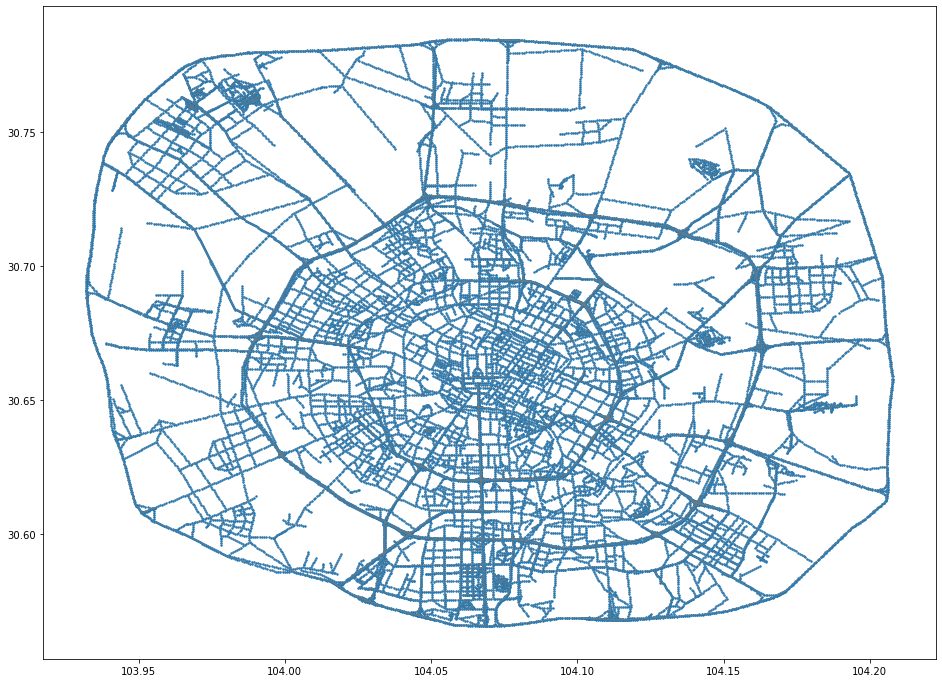

In [9]:
## Chengdu  
cd_nodes, cd_edges = read_map(CITIES[2], ROADS)
plot_map(cd_nodes, cd_edges)

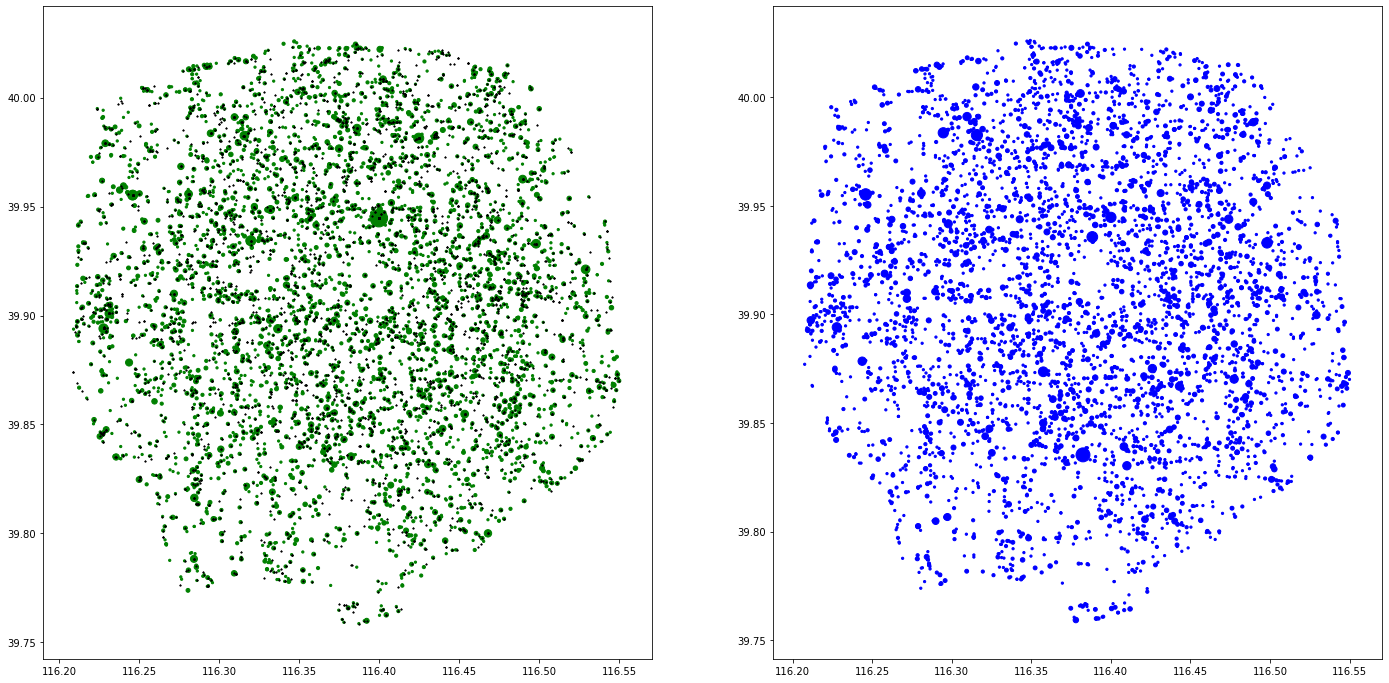

In [11]:
inst3 = 'rs-cd1-m5k-c3-d6-s10-x1.0.instance' 
trips3 = read_instance(path.join(getcwd(),'cargo', 'instances', inst3))
plot_trips(trips3, bj_nodes, car_positions=True)